In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
from matplotlib import font_manager as fm, rcParams
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

from pathlib import Path


from umap.umap_ import UMAP

from pointgrid import align_points_to_grid

#hdbscan
import hdbscan

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
subject_dict= {'A': 'Manuals', 'B': 'Italian Art', 'C': 'Italian Artists', 'D': 'Rome','E':'Italian Topography', 'F': 'Travel Literature', 
               'G': 'Sources', 'H': 'Iconography', 'J': 'Ornament','K': 'Kat and K', 'L': 'Congress Publications', 'M': 'Art in General',
                'N': 'Architecture', 'O':'Sculpture', 'P': 'Painting', 'Q': 'Manuscript Illumination', 'R': 'Graphic Arts', 
               'S': 'Applied Arts', 'T': 'Collecting Art, Museum Studies', 'U': 'Registers of Artistic Monuments', 'V': 'Cultural Institutions', 
               'W': 'Non-Italian Artists','X': 'European Topography', 'Y': 'World Topography', 'Z': 'Related Disciplines', ' ': 'None'}


custom_colours = ["#EA522B", "#EFD4D1", "#2A4978", "#8BDBE1", "#ECA19D", "#B48E36", "#E1DCE0", "#B8BFCE", "#E0DCD1", "#91C5E4", 
                  "#6E8EAC", "#D2E7E0", "#ECD096", "#6C9686", "#E6E10F", "#9D4B37", "#A3B49D", "#BDC920", "#DBE3E5", "#6A8B8D", "#EFB3D1"]
custom_cmap = ListedColormap(custom_colours)

In [7]:
# Import
path_in = '../data/hertziana_exp/freihand_signatures.csv'

df = pd.read_csv(path_in)
df.inventory_year = df.inventory_year.fillna(0).astype(int)
df = df.fillna('')

# 30'000 sample points for fast plotting
# df = df.sample(30000)

In [8]:
# text cols for wordclouds, cluster cols for clustering
text_cols = ['text', 'text_3', 'text_2', 'text_1']
cluster_cols = ['sig_lev_1', 'text_2', 'text_3']

# Perform one-hot encoding on the cluster_cols
df_cluster_1 = pd.get_dummies(df[cluster_cols[0]])
df_cluster_2 = pd.get_dummies(df[cluster_cols[:3]])


## 1. embedding: TF-IDF on titles

In [9]:
n_neighbors = 30
metric = 'cosine'
min_dist = 0.1

# TODO: languages? create statistics for languages
df_ita = df[df.lang == 'ger']

# Group the documents based on sig_lev_1
grouped = df.groupby('sig_lev_1')

# Create one long text out of the titles for each group
group_texts = {}
for group_name, group_df in grouped:
    titles = group_df['title'].tolist()
    long_text = ' '.join(titles)
    group_texts[group_name] = long_text

# Compute TF-IDF based on the long texts
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(group_texts.values())

#  Run UMAP on the TF-IDF matrix
umap_embedding = UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric).fit_transform(tfidf_matrix)

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


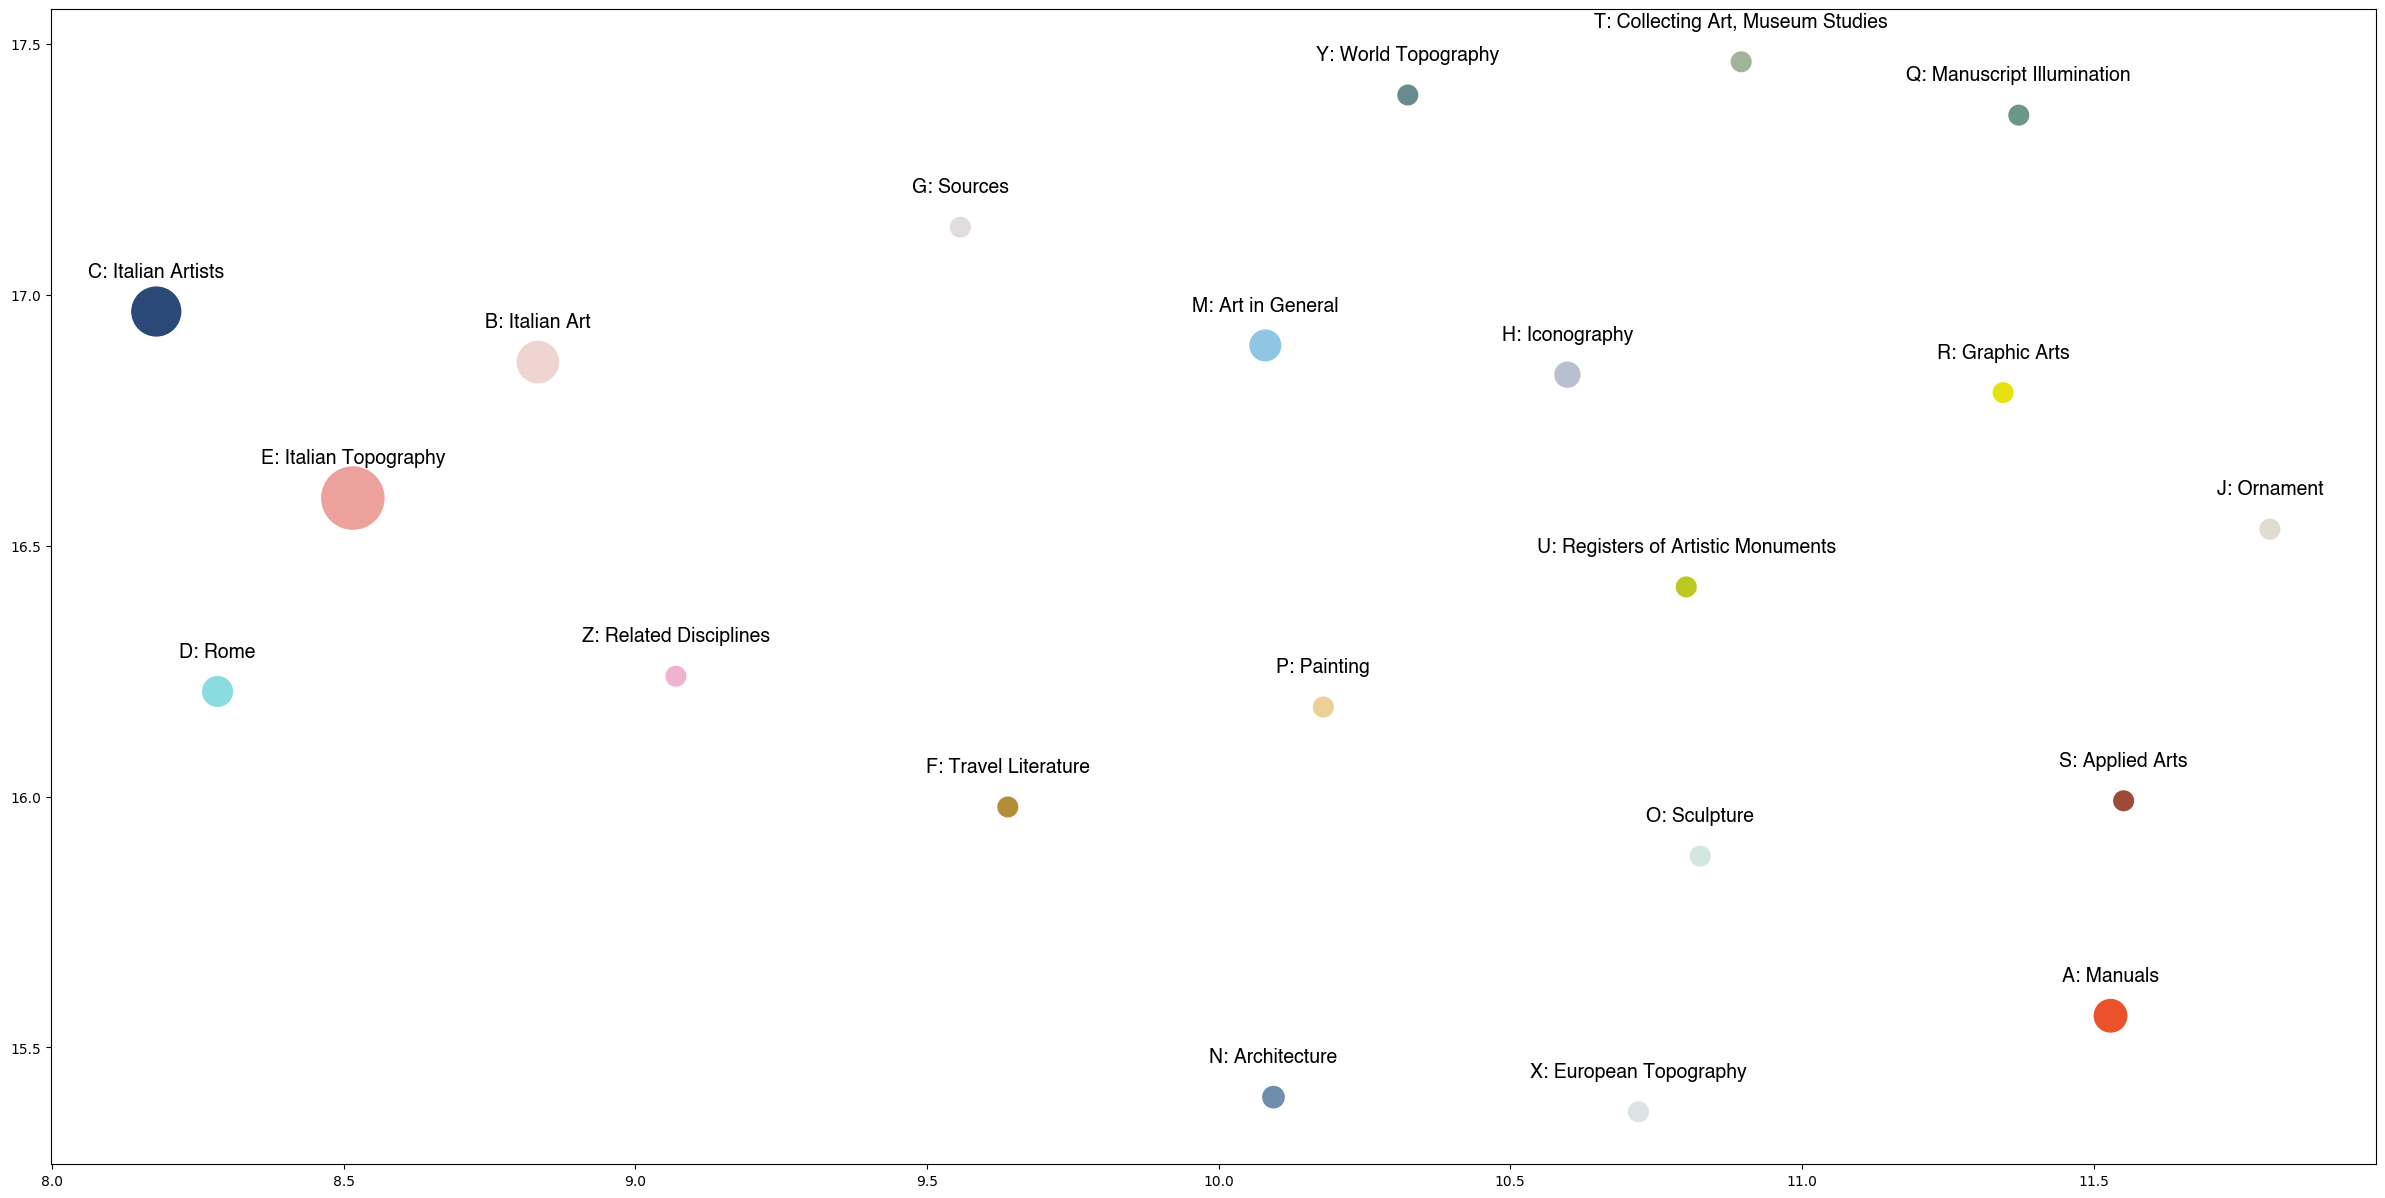

In [10]:
# Plot the points on the UMAP embedding and add labels
fig, ax = plt.subplots(figsize=(30, 15))

# Get the number of documents in each group
group_document_counts = [len(group_df) for group_name, group_df in grouped]

# Normalize the document counts to use as circle sizes
max_count = max(group_document_counts)
circle_sizes = np.array(group_document_counts) / max_count * 2000

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=range(len(group_texts)), cmap=custom_cmap, s=circle_sizes)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=range(len(group_texts)), cmap=custom_cmap, s=200)
for i, group_name in enumerate(group_texts.keys()):
    label = group_name + ': ' + subject_dict[group_name]
    x = umap_embedding[i, 0]
    y = umap_embedding[i, 1]
    plt.text(x, y + 0.08, label, fontsize=14,font= 'Helvetica', ha='center', va='center')
# ax.axis('off')
# plt.title("UMAP Embedding of titles \n")
plt.show()


# 2. embedding: running UMAP on second level

In [11]:
# Umap embedding for each cluster
embeddings_2 = []

for group_name, group_df in grouped:

    n_neighbors = 30
    metric = 'russellrao'
    min_dist = 0.1

    # Get the indices of the current group
    group_indices = group_df.index

    # Extract corresponding rows from df_cluster_2
    data = df_cluster_2.loc[group_indices]

    # Apply UMAP to the cluster again
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist,
                spread=1.0, random_state=42, verbose=False)
    x_umap = umap.fit_transform(data)

    embeddings_2.append(x_umap)

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellra

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/seaborn/relational.py:573

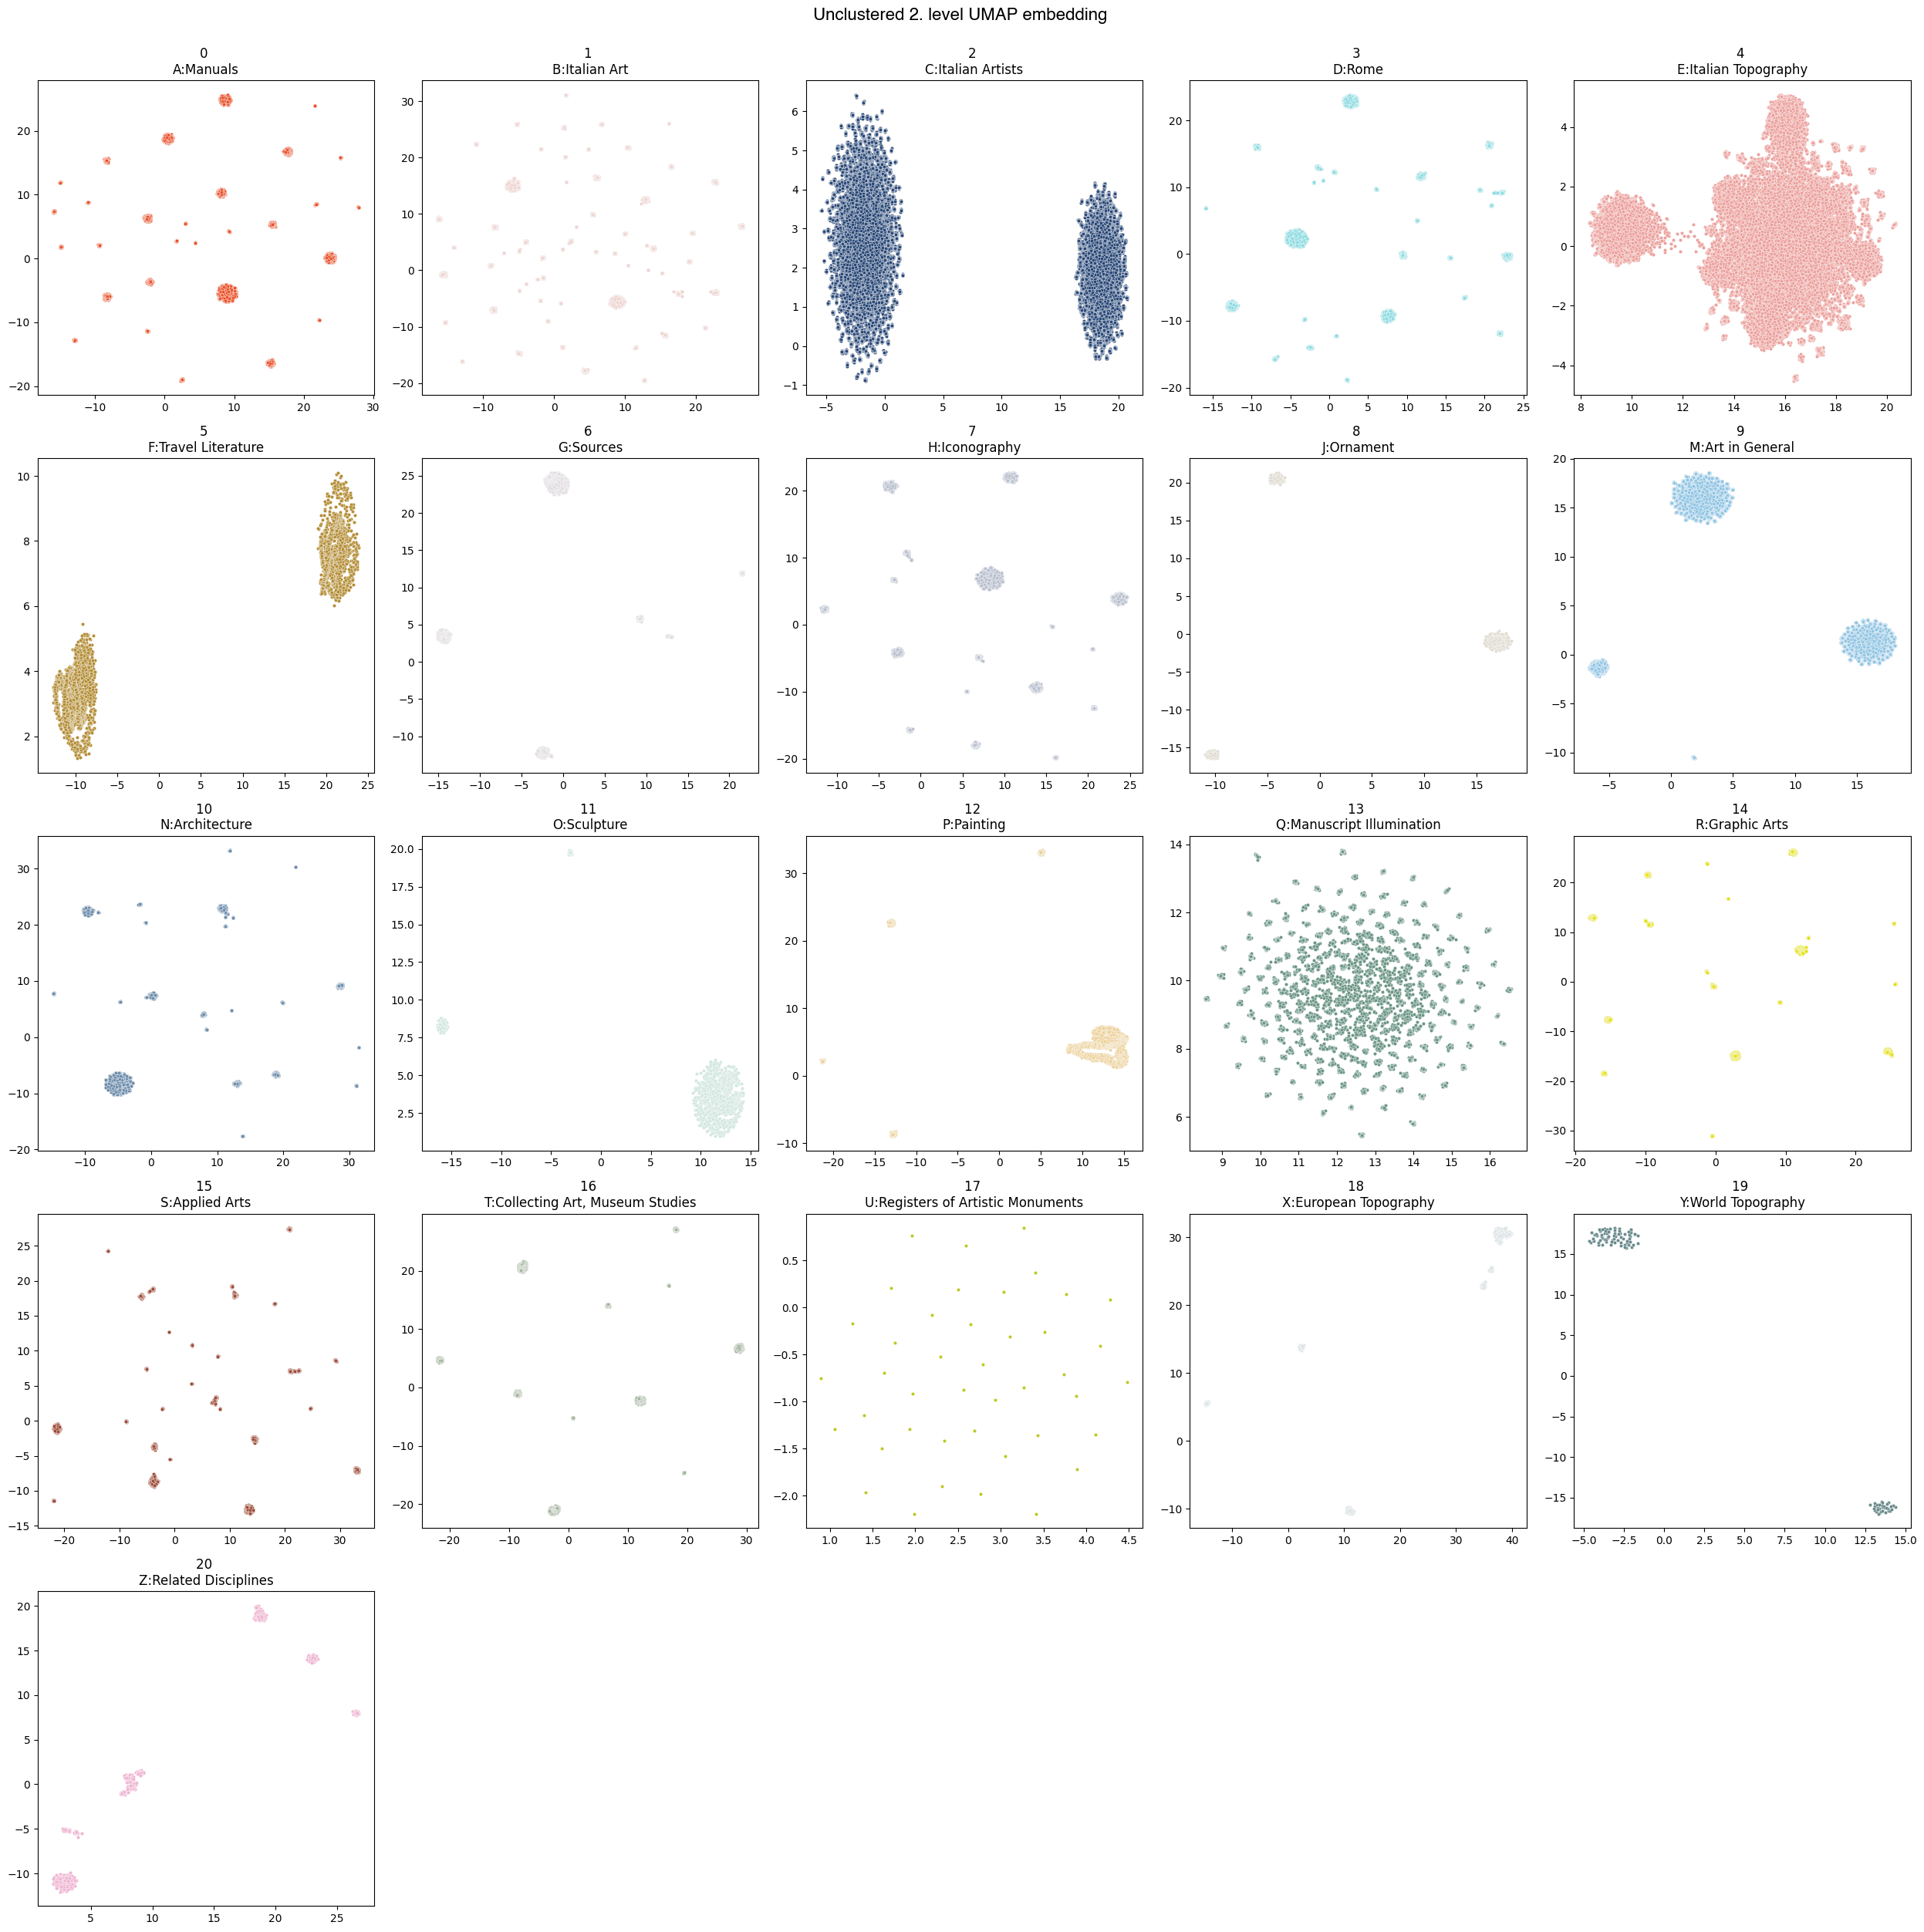

In [12]:
n_clusters = len(grouped)
n_rows = int(np.ceil(np.sqrt(n_clusters)))
n_cols = int(np.ceil(n_clusters / n_rows))

# Create the subplots for the level 2 embeddings
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows * 5, n_cols * 5))
axes = axes.flatten()

for i, (group_name, group_df) in enumerate(grouped):

    ax = axes[i]

    emb = embeddings_2[i]
    # labels = clusters_2[i][0]
    # clustered = clusters_2[i][1]

    rows = df.loc[group_df.index, :]
    order = sorted(rows.text_2.unique())
    color = custom_cmap(i / (n_clusters - 1))

    # Clustered datapoints
    sns.scatterplot(x=emb[:, 0], 
                    y=emb[:, 1], 
                    c=color,
                    ax=ax, 
                    s=10,)
        
    ax.set_title('{} \n{}:{}'.format(i, group_name, subject_dict[group_name]))

# Hide any extra subplots
for j in range(n_clusters, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.suptitle('Unclustered 2. level UMAP embedding', fontsize=16, y=1, font='Helvetica')
plt.tight_layout()
plt.show()

/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_1555/1869560874.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(assembled_embedding[group_indices, 0], assembled_embedding[group_indices, 1], c=color, s=0.5)


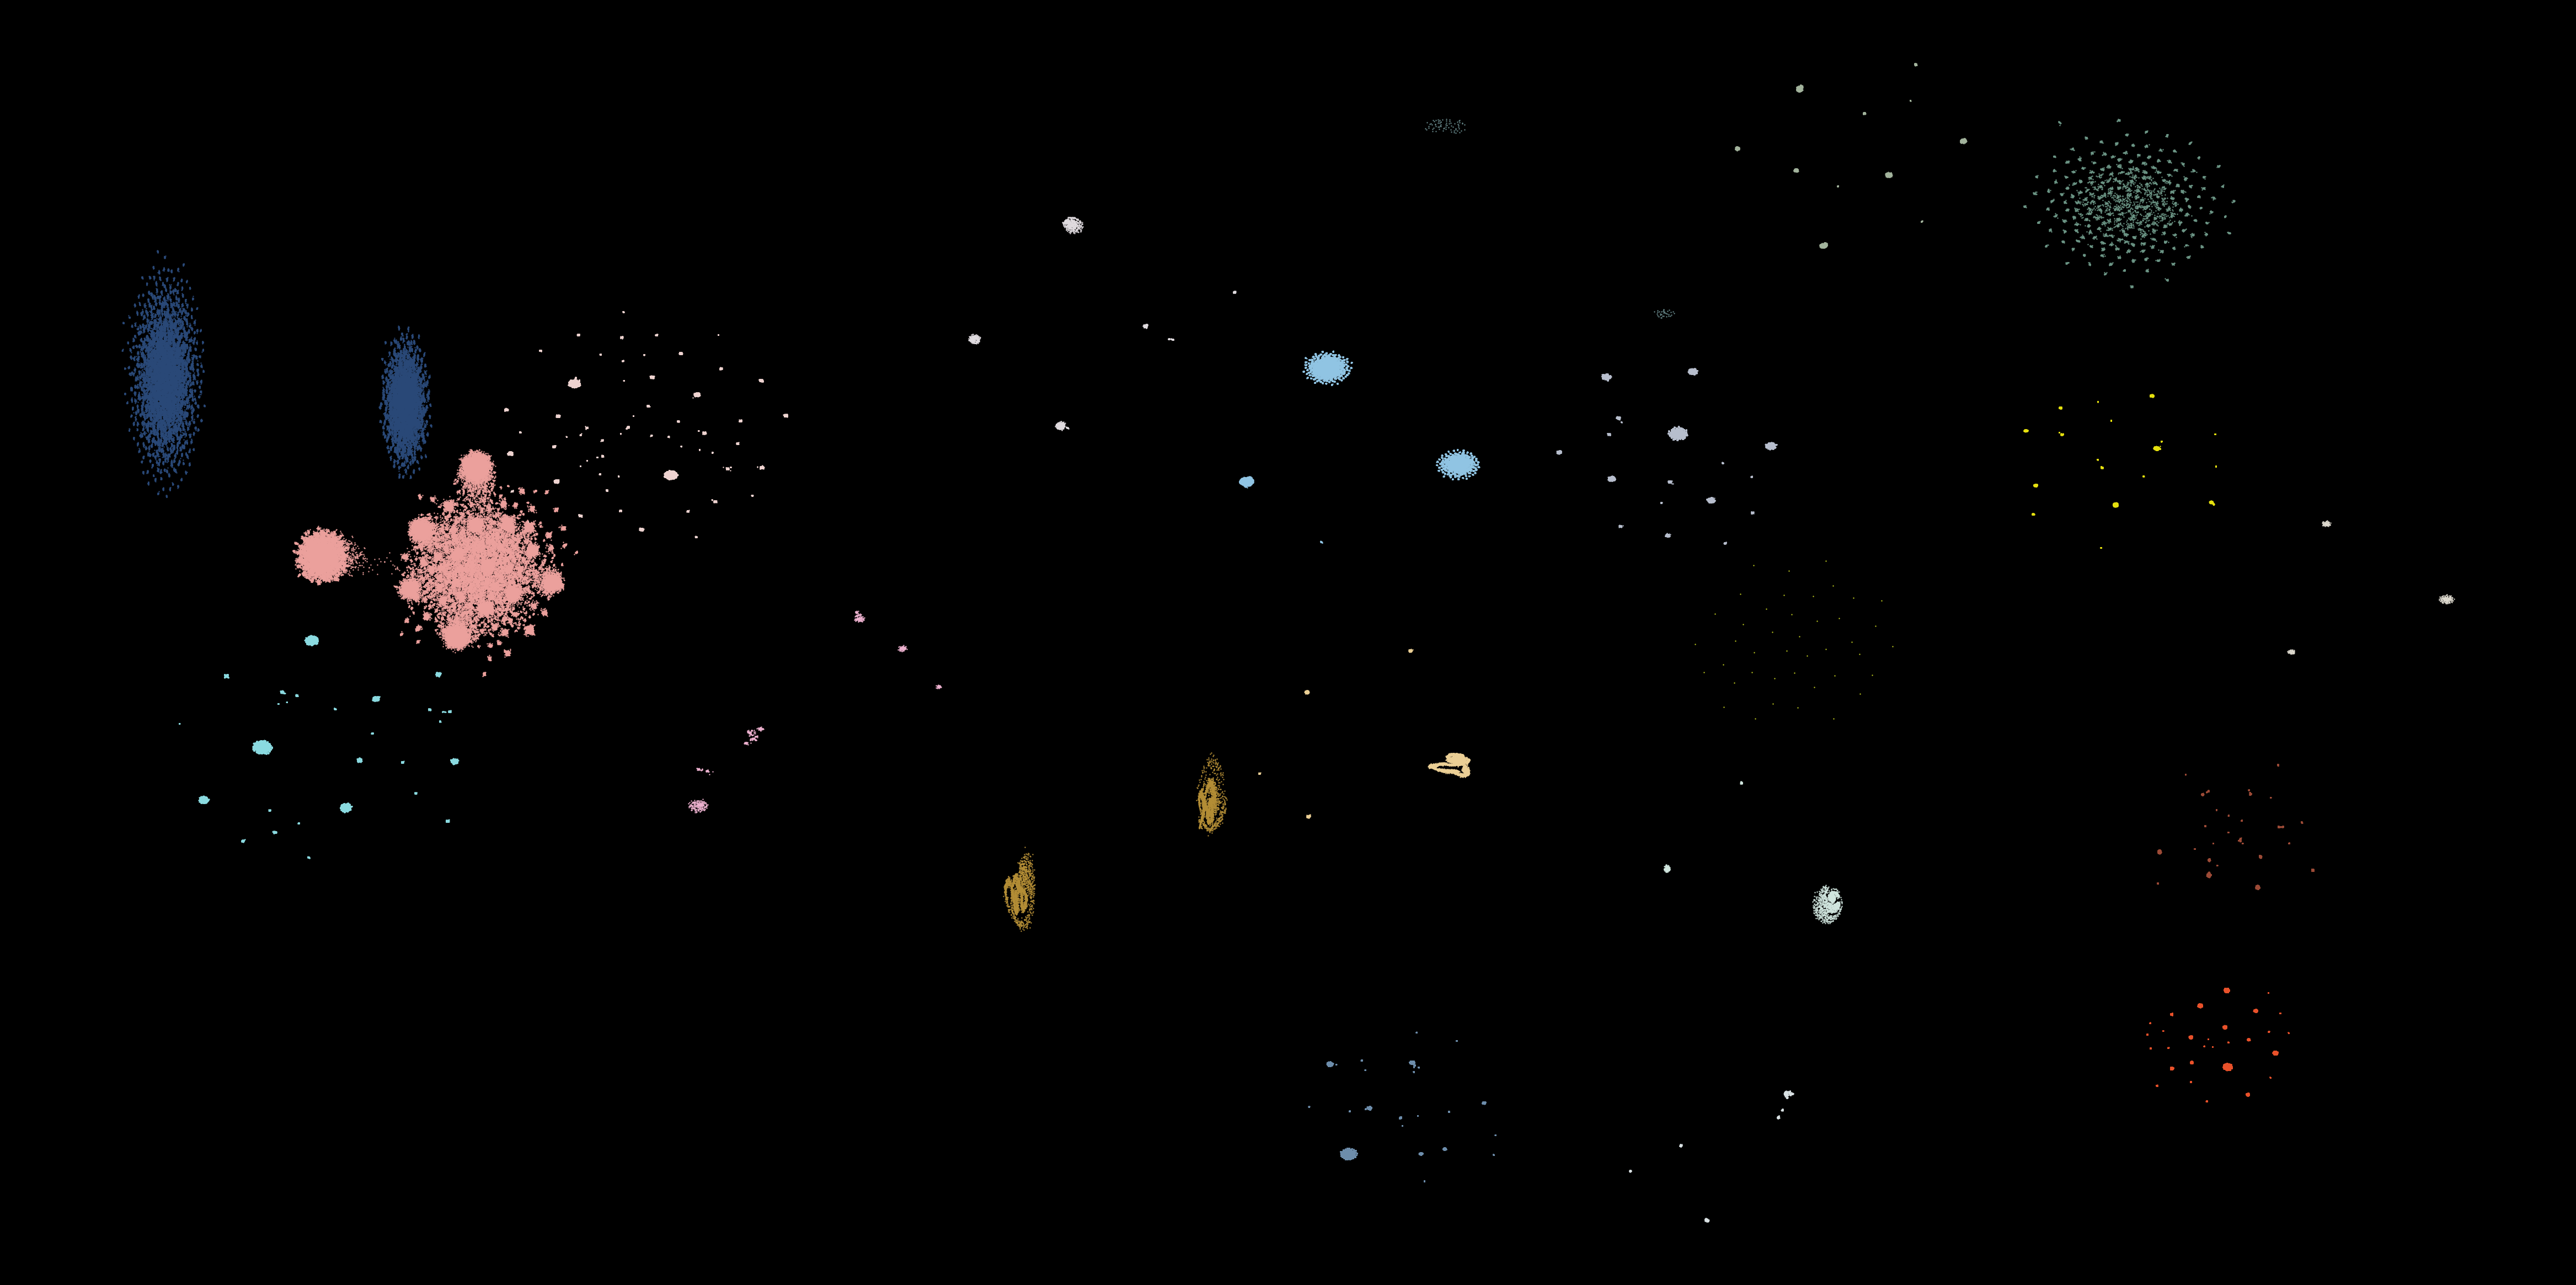

In [69]:
size = sum(len(group_df) for _, group_df in grouped)
assembled_embedding = np.empty((size, 2)) 
n_groups = len(grouped)

fig, ax = plt.subplots(figsize=(60, 30))
fig.patch.set_facecolor('black') 

for i, (group_name, group_df) in enumerate(grouped):
    centroid_1 = umap_embedding[i] 
    emb_2 = embeddings_2[i]
    group_indices = group_df.index
    color = custom_cmap(i / (n_groups - 1))

       
    scale_factor = np.ptp(umap_embedding[i] , axis=0) / np.ptp(emb_2, axis=0)
    scaled_emb_2 = emb_2 * scale_factor * 0.06 # scale factor 

    centroid_2_scaled = np.mean(scaled_emb_2, axis=0)
    centroid_diff = centroid_1 - centroid_2_scaled
    shifted_emb_2= scaled_emb_2 + centroid_diff

    assembled_embedding[group_indices] = shifted_emb_2
    
    plt.scatter(assembled_embedding[group_indices, 0], assembled_embedding[group_indices, 1], c=color, s=0.5)
    ax.axis('off')
    # for i, group_name in enumerate(group_texts.keys()):
    #     label = group_name + ': ' + subject_dict[group_name]
    #     x = umap_embedding[i, 0]
    #     y = umap_embedding[i, 1]
    #     plt.text(x, y + 0.1, label, fontsize=25,font='Helvetica', fontweight='light', ha='center', va='center')


    dpi = 300  # Adjust the DPI value as desired
    output_filename = f"data/plots/assembled_embedding_dark.png"  # Specify the desired output filename and format

    plt.savefig(output_filename, dpi=dpi)
    plt.close(fig)    
    



## Subplots clustering

In [ ]:
import os

# Directory to save the subplots
save_dir = 'data/plots/subplots/'
os.makedirs(save_dir, exist_ok=True)

n_clusters = len(grouped)

for i, (group_name, group_df) in enumerate(grouped):
    fig, ax = plt.subplots(figsize=(10, 10))

    emb = embeddings_2[i]
    rows = df.loc[group_df.index, :]
    order = sorted(rows.text_2.unique())
    color = custom_cmap(i / (n_clusters - 1))

    sns.scatterplot(x=emb[:, 0], 
                    y=emb[:, 1], 
                    c=color,
                    ax=ax, 
                    s=10)
        
    ax.set_title('{} \n{}:{}'.format(i, group_name, subject_dict[group_name]))

    # Save the subplot as a file
    save_path = os.path.join(save_dir, f'subplot_{group_name}.png')
    fig.savefig(save_path, dpi=300)

    plt.close(fig)  # Close the figure to release memory

print(f'Subplots saved in {save_dir}.')


In [13]:
clusters_2 = []

for i, (group_name, group_df) in enumerate(grouped):
    embedding = embeddings_2[i]

    min_size = len(embedding) // 200 if len(embedding) // 200 > 1 else 20  # min size of cluster depending on number of sample points
    min_samples = len(embedding) // 200 if len(embedding) // 200 > 1 else 20  # min samples of cluster depending on number of sample points

    labels = hdbscan.HDBSCAN(
        min_samples=min_samples,  # min-cluster-size: increase as dataset gets bigger
        min_cluster_size=min_size,  # min-sample: how conservative the clustering is
    ).fit_predict(embedding)

    # Clustered points
    clustered = (labels >= 0)
    values = set(labels)

    # Get the rows corresponding to the current group
    rows = group_df

    # Create subclusters based on labels
    subclusters = [[index for index, cluster in enumerate(labels) if cluster == value] for value in values]

    clusters_2.append((labels, clustered, subclusters))

In [18]:
for i, (group_name, group_df) in enumerate(grouped):
        fig, ax = plt.subplots(figsize=(19, 19))
        emb = embeddings_2[i]
        rows = group_df
        labels = clusters_2[i][0]
        clustered = clusters_2[i][1]
        subclusters = clusters_2[i][2]

        # Unclustered datapoints
        ax.scatter(
            emb[~clustered, 0],
            emb[~clustered, 1],
            color=(0, 0, 0),  # black points are not clustered
            s=5
        )

        color = custom_cmap(i / (len(grouped) - 1))
        # Clustered datapoints
        ax.scatter(
            emb[clustered, 0],
            emb[clustered, 1],
            c=color,
            s=5,
            alpha=0.8
        )

        ax.set_title('{}: {}'.format(group_name, subject_dict[group_name]))

        # Add labels to clusters
        positions, cluster_labels = [], []
        for j, cluster_points in enumerate(subclusters):
            text_2 = rows.iloc[cluster_points].text_2.value_counts().index[0].replace('_', ' ')
            # text_3 = rows.iloc[cluster_points].text_3.value_counts().index[0].replace('_', ' ')
            cluster_labels.append(f'{text_2}')

            centroid = np.mean(emb[cluster_points, :], axis=0)
            max_y_index = cluster_points[np.argmax(emb[cluster_points, 1])]
            positions.append([centroid[0], emb[max_y_index, 1]])

        for label, position in zip(cluster_labels, positions):
            ax.annotate(
                label, xy=position, xytext=(0, 0),
                textcoords='offset pixels',
                ha='center', va='center',
                fontsize=14, font='Helvetica'
            )

        save_path = 'data/plots/subplots/subplot_{}.png'.format(group_name)
        fig.savefig(save_path, dpi=300)
        plt.close(fig)

/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_54626/2230253963.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_54626/2230253963.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_54626/2230253963.py:19: UserWarning: *c* argument looks like a single numeric RGB or RG